In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from itertools import chain


# Define constants for column names

In [2]:
FINDING_LABELS_COLUMN = 'Finding Labels'

# Load the dataset

In [3]:
data = pd.read_csv('../data/NIH_Dataset/Data_Entry_2017.csv')
data = data[data['Patient Age'] < 100]  # Filter out entries with age >= 100


In [4]:
# Map image paths
# Define the base directory path where images are stored
base_path = '../data/NIH_Dataset'

# Use glob to find all PNG images in the nested directories and map them by their basename
image_paths = glob(os.path.join(base_path, 'images_*', 'images', '*.png'))

# Create a dictionary to map image file names to their full paths
image_path_dict = {os.path.basename(path): path for path in image_paths}

# Map image paths to the data entries
data['path'] = data['Image Index'].map(image_path_dict.get)

# Check for any entries that didn't find a corresponding path
missing_images = data[data['path'].isnull()]
print(f"Missing image paths: {missing_images.shape[0]}")

# Sample data to check the paths
data[['Image Index', 'path']].sample(5)

Missing image paths: 0


,Image Index,path
1060,00000255_000.png,../data/NIH_Dataset\images_001\images\00000255...
51810,00013080_000.png,../data/NIH_Dataset\images_006\images\00013080...
2015,00000514_004.png,../data/NIH_Dataset\images_001\images\00000514...
101573,00026982_003.png,../data/NIH_Dataset\images_011\images\00026982...
86294,00021277_018.png,../data/NIH_Dataset\images_010\images\00021277...


In [5]:

# Remove 'No Finding' labels and split labels
data[FINDING_LABELS_COLUMN] = data[FINDING_LABELS_COLUMN].apply(lambda x: x.replace('No Finding', ''))
all_labels = sorted(np.unique(list(chain(*data[FINDING_LABELS_COLUMN].map(lambda x: x.split('|')).tolist()))))


In [6]:
# Create binary labels using a lambda function with a default argument
for label in all_labels:
    data[label] = data['Finding Labels'].apply(lambda x, lbl=label: 1.0 if lbl in x else 0)


In [7]:
# Filter labels to keep only those that appear in at least 1000 cases
MIN_CASES = 1000
all_labels = [label for label in all_labels if data[label].sum() > MIN_CASES]
print('Clean Labels ({}):'.format(len(all_labels)), [(label, int(data[label].sum())) for label in all_labels])


Clean Labels (14): [('', 112104), ('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


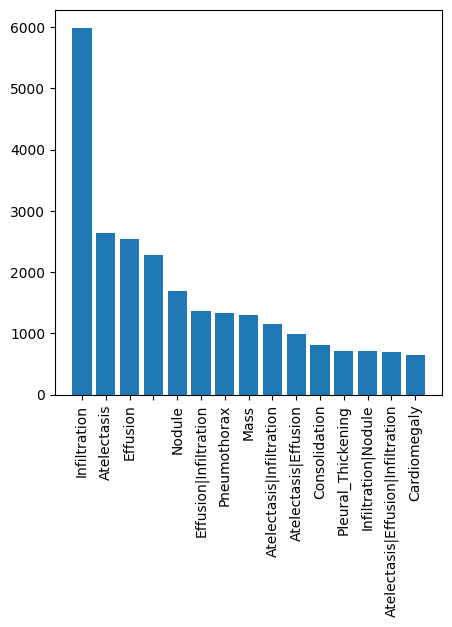

In [8]:
# Calculate sample weights based on the number of diseases diagnosed
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if x else 0).values + 0.04
sample_weights /= sample_weights.sum()

# Sample the data based on the computed weights to create a balanced dataset
data = data.sample(40000, weights=sample_weights)

# Visualize the distribution of findings
label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
ax1.set_xticklabels(label_counts.index, rotation=90)
plt.show()

In [9]:
# creating vector of diseases
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], axis=1).map(lambda x: x[0])
print(data.iloc[0]['disease_vec'])

[1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0]


In [10]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.Grayscale(),  # Convert to grayscale
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(5),  # Random rotation by 5 degrees
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1] range
])

In [11]:

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')  # Open the image file
        label = self.dataframe.iloc[idx][all_labels].values.astype(np.float32)

        if self.transform:
            image = self.transform(image)

        return image, label


In [12]:
# Create dataset
dataset = ChestXrayDataset(data, transform=transform)

# Splitting the dataset
train_size = int(0.75 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)

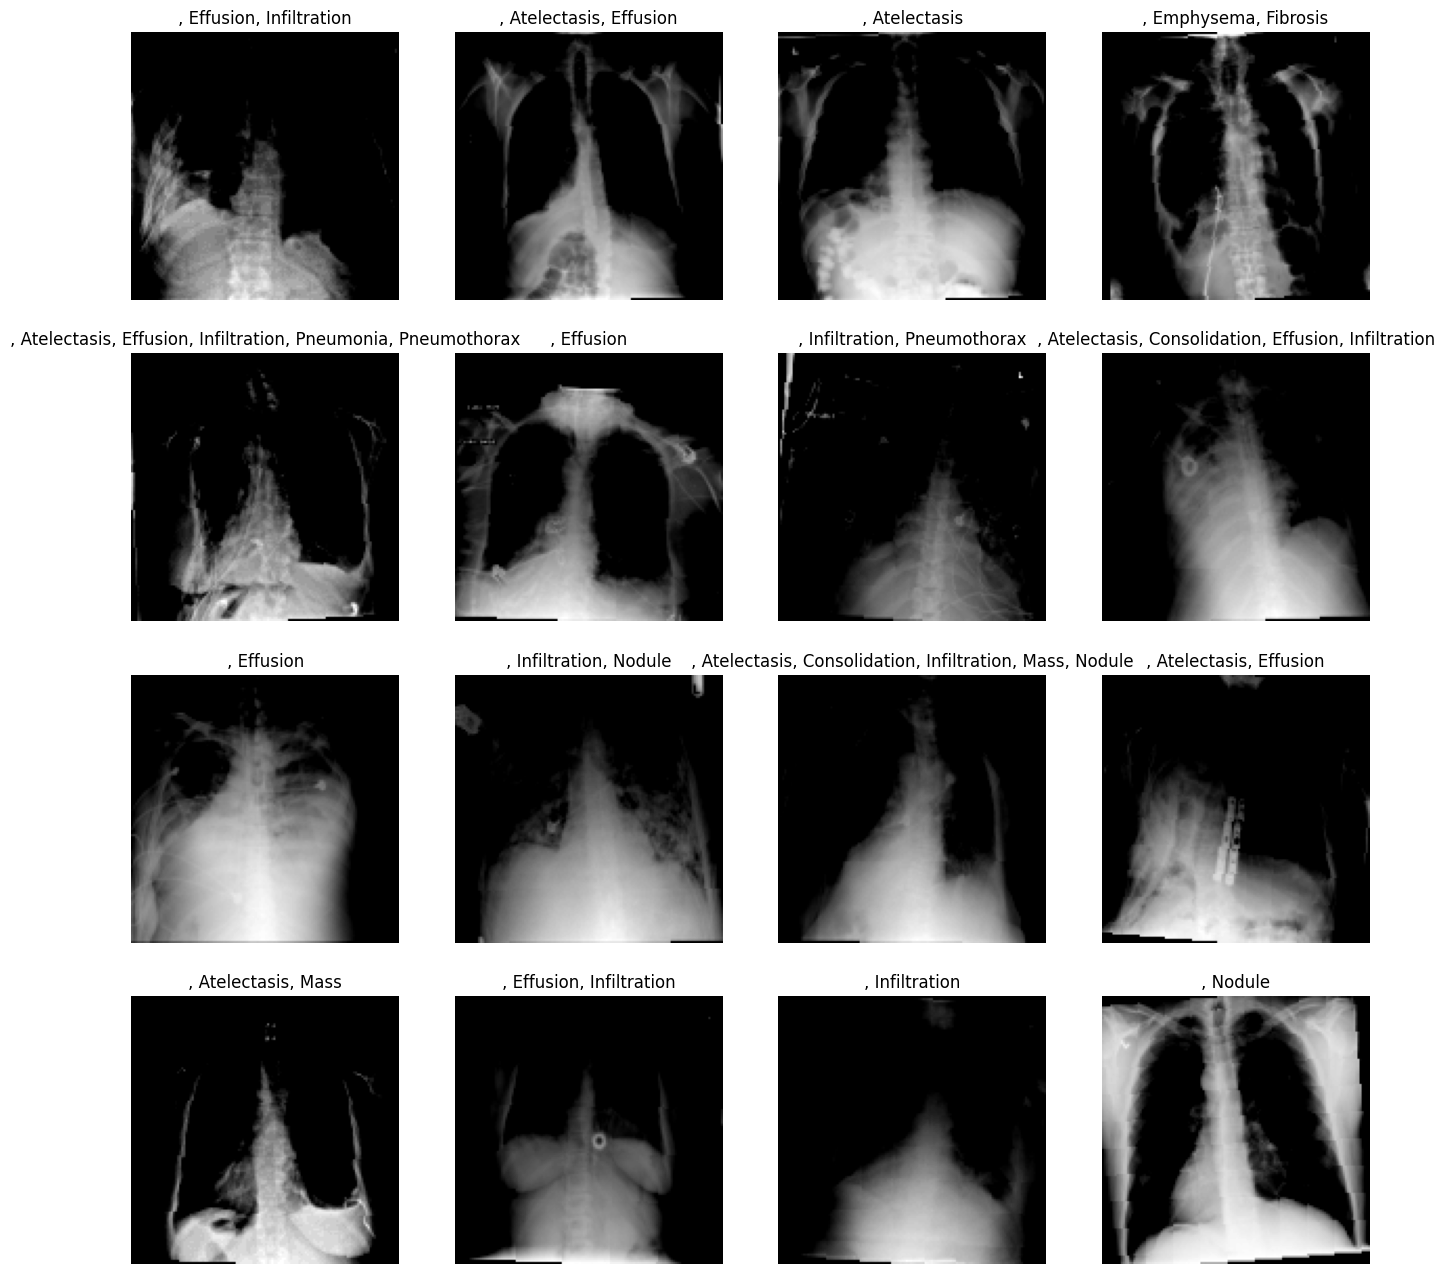

In [16]:
# Function to visualize images
def show_images(images, labels, all_labels, n=4):
    _, axs = plt.subplots(n, n, figsize=(16, 16))  # Adjust the size as needed
    axs = axs.flatten()
    for img, label, ax in zip(images, labels, axs):
        img = img.numpy().transpose((1, 2, 0))  # Adjust based on your image channel order
        img = np.clip(img, 0, 1)  # Normalize image data to 0-1 range
        label_text = ', '.join([all_labels[idx] for idx, present in enumerate(label) if present > 0.5])
        ax.imshow(img[:, :, 0], cmap='gray')  # Assuming img is grayscale
        ax.set_title(label_text)
        ax.axis('off')
    plt.show()

# Visualize some training images
images, labels = next(iter(train_loader))
show_images(images, labels, all_labels)